In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage.filters import convolve, gaussian_filter
from scipy.interpolate import interp2d
from random import sample

/var/folders/zs/kl_4mn7x77z1pzj6m2yc5f2w0000gn/T/ipykernel_72771/2782912191.py:4: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve, gaussian_filter
/var/folders/zs/kl_4mn7x77z1pzj6m2yc5f2w0000gn/T/ipykernel_72771/2782912191.py:4: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve, gaussian_filter


In [2]:
def flowToColor(flow, maxflow=None, verbose=False):
    '''
    args
        flow (numpy array) height x width x 2
    return
        img_color (numpy array) height x width x 3
    '''

    UNKNOWN_FLOW_THRESH = 5e2
    eps = 1e-6

    height, widht, nBands = flow.shape

    if nBands != 2:
        exit('flowToColor: image must have two bands')

    u = flow[:, :, 0]
    v = flow[:, :, 1]

    maxu = -999
    maxv = -999

    minu = 999
    minv = 999
    maxrad = -1

    # fix unknown flow
    idxUnknown = (abs(u) > UNKNOWN_FLOW_THRESH) | (abs(v) > UNKNOWN_FLOW_THRESH)
    u[idxUnknown] = 0
    v[idxUnknown] = 0

    maxu = max(maxu, u.max())
    minu = min(minu, u.min())

    maxv = max(maxv, v.max())
    minv = min(minv, v.min())

    rad = np.sqrt(u ** 2 + v ** 2)
    maxrad = max(maxrad, rad.max())

    if verbose:
        print('max flow: %.4f flow range: u = %.3f .. %.3f; v = %.3f .. %.3f\n' %
              (maxrad, minu, maxu, minv, maxv))

    if maxflow is not None:
        if maxflow > 0:
            maxrad = maxflow

    u = u / (maxrad + eps)
    v = v / (maxrad + eps)

    img = computeColor(u, v)

    # unknown flow
    # IDX = repmat(idxUnknown, [1, 1, 3])
    img[idxUnknown] = 0

    return img
def computeColor(u, v, cast_uint8=True):
    '''
    args
        u (numpy array) height x width
        v (numpy array) height x width
        cast_uint8 (bool) set False to have image range 0-1 (np.float32)
    return
        img_color (numpy array) height x width x 3
    '''

    nanIdx = np.isnan(u) | np.isnan(v)
    u[nanIdx] = 0
    v[nanIdx] = 0

    colorwheel = makeColorwheel()
    ncols = colorwheel.shape[0]

    rad = np.sqrt(u ** 2 + v ** 2)

    a = np.arctan2(-v, -u)/np.pi

    fk = (a + 1) / 2 * (ncols - 1)  # -1~1 maped to 1~ncols

    k0 = np.floor(fk).astype(int)  # 1, 2, ..., ncols

    k1 = k0 + 1
    k1[k1 == ncols + 1] = 1

    f = fk - k0

    height, width = u.shape
    img = np.zeros((height, width, 3), np.float32)
    nrows = colorwheel.shape[1]
    for i in range(nrows):
        tmp = colorwheel[:, i]
        col0 = tmp[k0.reshape(-1)] / 255
        col1 = tmp[k1.reshape(-1)] / 255
        col = col0.reshape(height, width) * (1 - f) + \
              col1.reshape(height, width) * f

        idx = rad <= 1
        col[idx] = 1 - rad[idx] * (1 - col[idx])  # increase saturation with radius

        col[np.logical_not(idx)] *= 0.75  # out of range

        img[:, :, i] = col * (1 - nanIdx)

    if cast_uint8:
        img = np.floor(img * 255).astype(np.uint8)
    return img


def makeColorwheel():
    '''
    color encoding scheme
    adapted from the color circle idea described at
    http://members.shaw.ca/quadibloc/other/colint.htm
    '''

    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR

    colorwheel = np.zeros((ncols, 3))  # r g b

    col = 0
    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.floor(255*np.array(range(RY))/RY)
    col = col+RY

    # YG
    colorwheel[col:col+YG, 0] = 255 - np.floor(255*np.array(range(YG))/YG)
    colorwheel[col:col+YG, 1] = 255
    col = col+YG

    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.floor(255*np.array(range(GC))/GC)
    col = col+GC

    # CB
    colorwheel[col:col+CB, 1] = 255 - np.floor(255*np.array(range(CB))/CB)
    colorwheel[col:col+CB, 2] = 255
    col = col+CB

    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.floor(255*np.array(range(BM))/BM)
    col = col+BM

    # MR
    colorwheel[col:col+MR, 2] = 255 - np.floor(255*np.array(range(MR))/MR)
    colorwheel[col:col+MR, 0] = 255

    return colorwheel


In [3]:
def myFlow(img1, img2, window_length, tau):
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY) / 255.0
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY) / 255.0

    derivative_filter = np.array([-1, 8, 0, -8, 1]) / 12
    Ix = convolve(gray1, derivative_filter[np.newaxis])
    Iy = convolve(gray1, derivative_filter[np.newaxis].T)

    blurred1 = gaussian_filter(gray1, sigma=1)
    blurred2 = gaussian_filter(gray2, sigma=1)
    It = blurred2 - blurred1

    u = np.zeros_like(gray1)
    v = np.zeros_like(gray1)
    v_flow = np.zeros_like(gray1, dtype=bool)

    w = window_length // 2

    for y in range(w, gray1.shape[0] - w):
        for x in range(w, gray1.shape[1] - w):
            Ix_window = Ix[y - w:y + w + 1, x - w:x + w+ 1]
            Iy_window = Iy[y - w:y + w + 1, x - w:x + w + 1]
            It_window = It[y - w:y + w + 1, x - w:x + w + 1]

            A = np.vstack((Ix_window.flatten(), Iy_window.flatten())).T
            b = -It_window.flatten()

            if np.linalg.det(A.T @ A) < tau:
                continue

            uv = np.linalg.inv(A.T @ A) @ A.T @ b
            u[x, y], v[x, y] = uv
            v_flow[y, x] = True

    return u, v, v_flow

In [4]:
img1 = cv2.imread('sphere_0.png').astype(np.float32)
img2 = cv2.imread('sphere_1.png').astype(np.float32)

In [5]:
u,v, v_flow= myFlow(img1, img2, 13 , 0.000001)

In [10]:
u = np.dstack(u)
v = np.dstack(v)

In [11]:
v.shape

(200, 200, 1)

In [12]:
u.shape

(200, 200, 1)

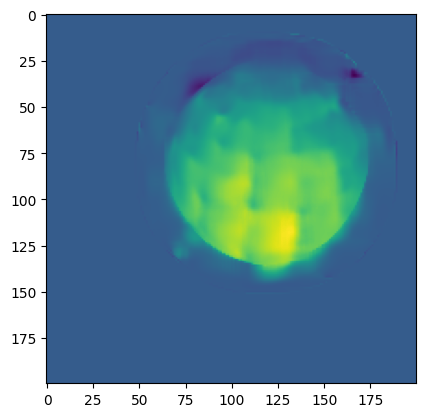

In [13]:
plt.imshow(u)

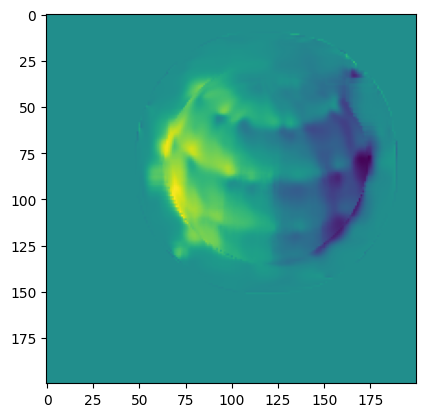

In [14]:
plt.imshow(v)

In [15]:
v_flow = np.dstack((u,v))

In [16]:
v_flow.shape

(200, 200, 2)

In [17]:
final = flowToColor(v_flow, maxflow=None, verbose=False)

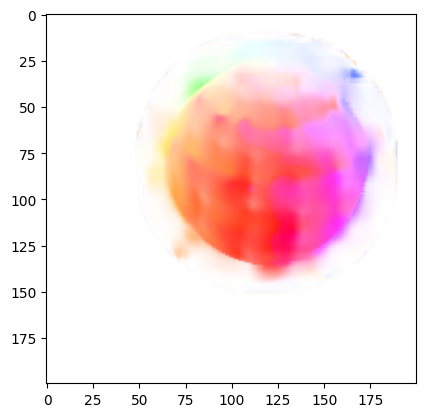

In [18]:
plt.imshow(final)